In [1]:
import ligo.skymap

In [2]:
import numpy as np
import time
import datetime
from astropy.time import Time
from urllib.request import urlopen
from bs4 import BeautifulSoup
import math
import ephem
def unix2met(unixtime):
    """Convert Unix time to Spacecraft time"""
    return int(unixtime) - time.mktime((2001,1,1,0,0,0,0,0,0))+(unixtime-int(unixtime))

Attitude

In [3]:
from astropy.time import Time
import requests
import urllib.parse
import os, sys, json

def unix2mjd(unixtime):
    """Convert UNIX timestamp into MJD"""
    dt = Time(unixtime,format='unix',scale='utc')
    return dt.mjd

def get_attitude(trigtime_obj):
  unixtime=time.mktime(trigtime_obj.timetuple())
  mjd=unix2mjd(unixtime)
  base = 'https://www.swift.psu.edu/operations/afst_json.php?mjdstart='
  url = base+str(mjd)
  r = requests.get(url = url)
  settle_time = datetime.datetime.strptime(json.loads(r.text)['api_data']['entries'][0]['api_data']['settle'], "%Y-%m-%d %H:%M:%S")
  if trigtime_obj<settle_time:
    print('WARNING: Trigger time in slew. ObsSchedule pointing info not reliable. Must use attitude file.')
    return -1,-1,-1
  else:
    ra=float(json.loads(r.text)['api_data']['entries'][0]['api_data']['ra'])
    dec=float(json.loads(r.text)['api_data']['entries'][0]['api_data']['dec'])
    roll=float(json.loads(r.text)['api_data']['entries'][0]['api_data']['roll'])
    return ra,dec,roll

Attitude File Method

In [4]:

url = 'https://www.swift.ac.uk/archive/reproc/03110829010/auxil/sw03110829010sat.fits.gz'
from astropy.utils.data import download_file
from astropy.io import fits

attfile = download_file(url)

att = fits.open(attfile)
att_data=att[1].data
utcf=att[1].header['utcfinit']
print(T0-utcf)
for pointing in att_data:
    if abs(pointing[0]-T0+utcf) < 1:
        print(pointing)

NameError: name 'T0' is not defined

In [5]:
utcf

-26.05738

# Query the BAT polygon I made for Treasure Map

In [5]:
api_token = 'zeH0plj1hlUo0OWskopBddaQB8M8VwwYc1m86Q'
BASE = 'http://treasuremap.space/api/v0'


#Using this function to convert the string Polygons to a list of points
def sanatize_footprint_ccds(ccds):
    footprint_ccds = []
    for footprint in ccds:
        sanitized = footprint.strip('POLYGON ').strip(')(').split(',')
        polygon = []
        for vertex in sanitized:
            obj = vertex.split()
            ra = float(obj[0])
            dec = float(obj[1])
            polygon.append([ra,dec])
        footprint_ccds.append(polygon)
    return footprint_ccds

Requested Footprint Info


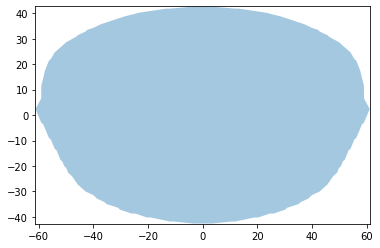

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

TARGET = 'footprints'

params = {
            "api_token":api_token,
            "name":"Swift Burst Alert Telescope"
        }

url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))
r = requests.get(url = url)

print("Requested Footprint Info")

footprints = json.loads(r.text)
polygons = []
patches = []

#This gets all of the Polygon information from the json list
for f in footprints:
    f_info = json.loads(f)
    polygons.append(f_info['footprint'])

#converts the polygons to a list of list of points (list of polygons)
sanatized_ccds = sanatize_footprint_ccds(polygons)

#gather the points for ylim and xlim
xs, ys = [], []

for sc in sanatized_ccds:
    #add the polygon list of points to the matplotlib patch collection
    patches.append(Polygon(sc, False))
    for p in sc:
        xs.append(p[0])
        ys.append(p[1])
    
p = PatchCollection(patches, alpha=0.4)

fig, ax = plt.subplots()
ax.set_xlim(min(xs)-.1, max(xs)+.1)
ax.set_ylim(min(ys)-.1, max(ys)+.1)
ax.add_collection(p)
plt.show()

In [7]:
def ra_dec_to_uvec(ra, dec):
    phi = np.deg2rad(90 - dec)
    theta = np.deg2rad(ra)
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    return x, y, z

def uvec_to_ra_dec(x, y, z):
    r = np.sqrt(x**2 + y ** 2 + z ** 2)
    x /= r
    y /= r
    z /= r
    theta = np.arctan2(y, x)
    phi = np.arccos(z)
    dec = 90 - np.rad2deg(phi)
    if theta < 0:
        ra = 360 + np.rad2deg(theta)
    else:
        ra = np.rad2deg(theta)
    return ra, dec

def x_rot(theta_deg):
    theta = np.deg2rad(theta_deg)
    return np.matrix([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])

def y_rot(theta_deg):
    theta = np.deg2rad(theta_deg)
    return np.matrix([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

def z_rot(theta_deg):
    theta = np.deg2rad(theta_deg)
    return np.matrix([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])


def project_footprint(footprint, ra, dec, pos_angle):
    if pos_angle is None:
        pos_angle = 0.0

    footprint_zero_center_ra = np.asarray([pt[0] for pt in footprint])
    footprint_zero_center_dec = np.asarray([pt[1] for pt in footprint])
    footprint_zero_center_uvec = ra_dec_to_uvec(footprint_zero_center_ra, footprint_zero_center_dec)
    footprint_zero_center_x, footprint_zero_center_y, footprint_zero_center_z = footprint_zero_center_uvec
    proj_footprint = []
    for idx in range(footprint_zero_center_x.shape[0]):
        vec = np.asarray([footprint_zero_center_x[idx], footprint_zero_center_y[idx], footprint_zero_center_z[idx]])
        new_vec = vec @ x_rot(-pos_angle) @ y_rot(dec) @ z_rot(-ra)
        new_x, new_y, new_z = new_vec.flat
        pt_ra, pt_dec = uvec_to_ra_dec(new_x, new_y, new_z)
        proj_footprint.append([pt_ra, pt_dec])
    return proj_footprint

# Plot that BAT footprint on top of a GW or Fermi skymap

In [8]:
from ligo.skymap.io import *
import ligo.skymap
#from ligo.skymap.tool.ligo_skymap_plot import main
import ligo.skymap.io
import ligo.skymap.postprocess

In [9]:
import numpy as np
from astropy.utils.data import download_file

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

from matplotlib import rcParams
%matplotlib inline
import matplotlib.pyplot as plt


In [10]:
import healpy as hp


Stuff needed for Earth occultation plotting

In [11]:
def getDataFromTLE(datetime, tleLatOffset=0, tleLonOffset=0.21):
    # Get TLE and parse
    url = "https://celestrak.com/satcat/tle.php?CATNR=28485"
    data = urlopen(url)
    tle_raw=data.read()
    clean_tle = ''.join(BeautifulSoup(tle_raw, "html.parser").stripped_strings)
    tle_obj = clean_tle.split('\r\n')

    # Print age of TLE
    year = "20"+tle_obj[1][18:20]
    day = tle_obj[1][20:32]
    #print("\nTLE most recently updated "+year+"DOY"+ day)
    
    # Create spacecraft instance
    Swift = ephem.readtle(tle_obj[0],tle_obj[1],tle_obj[2])
    
    # Create observer
    observer_Swift = ephem.Observer()
    observer_Swift.lat = '0'
    observer_Swift.long = '0'
    
    # Initialize lists
    lat = []
    lon = []
    elevation = []
    
    # Iterate through time; compute predicted locations
    observer_Swift.date = ephem.date(datetime)
    
    try:
        Swift.compute(observer_Swift)
    except:
        print('Cant compute observer, maybe TLE too old?')
        return False, False, False

    lat.append(np.degrees(Swift.sublat.znorm))
    lon.append(np.degrees(Swift.sublong.norm))
    elevation.append(Swift.elevation)
    # Correct for inaccuracy
    lon = np.array(lon) - tleLonOffset
    lat = np.array(lat) - tleLatOffset
    
    if len(lon) == 1: # Return single value instead of array if length is 1
        lon = lon[0]
        lat = lat[0]
        elevation = elevation[0]

    return lon, lat, elevation

In [12]:
def deg2dm(deg):
    sign = np.sign(deg)
    deg = np.abs(deg)
    d = np.floor(deg)
    m = (deg - d) * 60
    return int(sign*d), m

In [13]:
def getGeoCenter(datetime, lon, lat):
    # Define the observer to be at the location of the spacecraft
    observer = ephem.Observer()

    # Convert the longitude to +E (-180 to 180)
    if lon > 180:
       lon = (lon % 180) - 180

    lon_deg, lon_min = deg2dm(lon)
    lat_deg, lat_min = deg2dm(lat)

    lon_string = '%s:%s' % (lon_deg, lon_min)
    lat_string = '%s:%s' % (lat_deg, lat_min)

    observer.lon = lon_string
    observer.lat = lat_string
    
    # Set the time of the observations
    observer.date = ephem.date(datetime)
    
    # Get the ra and dec (in radians) of the point in the sky at altitude = 90 (directly overhead)
    ra_zenith_radians, dec_zenith_radians = observer.radec_of('0', '90')
    
    # convert the ra and dec to degrees
    ra_zenith = np.degrees(ra_zenith_radians)
    dec_zenith = np.degrees(dec_zenith_radians)
    
    ra_geocenter =  (ra_zenith+180) % 360
    dec_geocenter = -1 * dec_zenith
    
    return ra_geocenter, dec_geocenter

In [14]:
def getearthsatpos(datetime):
    tleLonOffset=0.21
    tleLatOffset = 0

    try:
        lon, lat, elevation= getDataFromTLE(datetime, tleLatOffset=tleLatOffset, tleLonOffset=tleLonOffset)
    except:
        return False, False, False

    if lon == False and lat == False and elevation == False:
        return False, False, False

    # Get the geo center coordinates in ra and dec
    ra_geocenter, dec_geocenter = getGeoCenter(datetime, lon, lat)

    EARTH_RADIUS = 6378.140 * 1000 #in meters
    dtor = math.pi/180
    elev = elevation + EARTH_RADIUS
    earthsize_rad = np.arcsin(EARTH_RADIUS/elev)/dtor

    return ra_geocenter,dec_geocenter, earthsize_rad

In [15]:
def makeEarthContour(ra,dec,radius):
    thetas = np.linspace(0, -2*np.pi, 200)
    ras = radius * np.cos(thetas)
    decs = radius * np.sin(thetas)
    contour = np.c_[ras,decs]
    Earthcont = project_footprint(contour, ra, dec, 0)
    return Earthcont

Code for splitting polygons if they span 0 deg RA

In [16]:
from operator import itemgetter
def splitter(batfootprint):
  hi=[]
  lo=[]
  for coord in batfootprint:
    if coord[0]>180:
      hi.append([coord[0],coord[1]])
    else:
      lo.append([coord[0],coord[1]])
  hi=sorted(hi,key=itemgetter(1))


  step = abs(lo[-1][1]-lo[0][1])/20
  if lo[-1][1] > 0:
    init = lo[-1][1]
  else:
    init = lo[0][1]
  for i in range(20):
    lo.append([0.1,init-i*step])

  step = abs(hi[-1][1]-hi[0][1])/20
  while step < 0.1:
    hi= hi[:-1]
    step = abs(hi[-1][1]-hi[0][1])/20
  if hi[-1][1] > 0:
    init = hi[-1][1]
  else:
    init = hi[0][1]
  for i in range(20):
    hi.append([359.9,init-i*step])

  return lo,hi

Make the damn figure already

In [17]:
s='2020-07-18T22:12:32'
trigtime_obj=datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
print(trigtime_obj)
unixtime = time.mktime(trigtime_obj.timetuple())
print(unixtime)
T0=unix2met(unixtime)
print(T0+25.385)

2020-07-18 22:12:32
1595124752.0
616799577.385


In [18]:
ra,dec,roll = get_attitude(trigtime_obj)
print(ra,dec,roll)

IndexError: list index out of range

In [19]:
batfootprint=project_footprint(sc, ra,dec,360-roll)

NameError: name 'ra' is not defined

In [22]:
url = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2020/bn201227635/quicklook/glg_healpix_all_bn201227635.fit'
skymapfile = download_file(url, cache=True) 
#skymap, metadata = ligo.skymap.io.fits.read_sky_map(url, nest=True, distances=False)

#nside=hp.get_nside(skymap)
skymap = hp.read_map(skymapfile)
nside = 128
deg2perpix = hp.nside2pixarea(nside, degrees=True)
probperdeg2 = skymap / deg2perpix
annotate = True
contour = (50,90)

/home/aaron/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/aaron/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 128
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/aaron/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/aaron/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/aaron/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to 

In [20]:
fig = plt.figure(figsize=(15, 15), dpi=100)

center = SkyCoord(116, -72, unit="deg")  # defaults to ICRS frame
ax = plt.axes(projection='astro hours mollweide')#, center = center, radius = 50*u.degree)#radius, center options
ax.grid()
try:
  vmax = probperdeg2.max()
  img = ax.imshow_hpx((probperdeg2, 'ICRS'), nested=False, vmin=0., vmax=vmax, cmap='cylon')
  cls = 100* ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap)
  cs = ax.contour_hpx((cls, 'ICRS'), nested=metadata['nest'],colors='k', linewidths=0.5, levels=(50,90))
except:
  print('No map')
fmt = r'%g\%%' if rcParams['text.usetex'] else '%g%%'
#plt.clabel(cs, fmt=fmt, fontsize=6, inline=True)


ra,dec,radius = getearthsatpos(trigtime_obj)
earthfoot=makeEarthContour(ra,dec,radius)
from matplotlib.patches import Polygon
earth = Polygon( earthfoot, facecolor='blue', edgecolor='green', alpha=0.4, closed=True, transform=ax.get_transform('fk5'))
ax.add_patch(earth)

ax.plot_coord(SkyCoord(150, 69, unit='deg'),'o',markerfacecolor ='blue',markersize=10)
ax.text(150, 69,'FRB', transform=ax.get_transform('fk5'),fontsize=15, color='blue')


# poly = Polygon( batfootprint, facecolor='green', edgecolor='green', alpha=0.4, closed=True, transform=ax.get_transform('fk5'))
# ax.add_patch(poly)

split=True
if split:
  lo,hi=splitter(batfootprint)
  polylo = Polygon( lo, facecolor='green', edgecolor='green', alpha=0.4, closed=True, transform=ax.get_transform('fk5'))
  ax.add_patch(polylo)
  polyhi = Polygon( hi, facecolor='green', edgecolor='green', alpha=0.4, closed=True, transform=ax.get_transform('fk5'))
  ax.add_patch(polyhi)


ligo.skymap.plot.outline_text(ax)
plt.title('FRB 200206a M81')

ValueError: Unknown projection 'astro hours mollweide'

<Figure size 1500x1500 with 0 Axes>

In [24]:
import swifttools

ModuleNotFoundError: No module named 'swifttools'